In [2]:
import sys
import os
import ctypes


# Get the absolute path of the utils directory
utils_path = os.path.abspath("lib")
sys.path.append(utils_path)
%load_ext autoreload
%autoreload 2

In [3]:
class mrh:
    def __init__(self, *args, **kwargs):
        pass

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import qiskit.qpy as qpy
import pickle
import json
import matplotlib.patches as mpatches
from numba import njit
from numba.typed import List
from plotting import *
from readings import *
from tile_process import *

In [5]:
N = 24; f_orbs = (2,2,2,2,2,2)
seam_lst = [8,16]
epsilon = 0.01
prehead = "../data_cr2_12o/"
uop, all_g = read_uop(1, epsilon,prehead)
# excitations = to_numba_typed_list(excitations)


Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


In [6]:
print(uop.a_idxs)
print(all_g)
print(uop.a_idxs[-1])


[array([6], dtype=uint8), array([18], dtype=uint8), array([6], dtype=uint8), array([18], dtype=uint8), array([6], dtype=uint8), array([18], dtype=uint8), array([6], dtype=uint8), array([18], dtype=uint8), array([6], dtype=uint8), array([18], dtype=uint8), array([6], dtype=uint8), array([18], dtype=uint8), array([7], dtype=uint8), array([19], dtype=uint8), array([7], dtype=uint8), array([19], dtype=uint8), array([7], dtype=uint8), array([19], dtype=uint8), array([7], dtype=uint8), array([19], dtype=uint8), array([7], dtype=uint8), array([19], dtype=uint8), array([7], dtype=uint8), array([19], dtype=uint8), array([8], dtype=uint8), array([20], dtype=uint8), array([8], dtype=uint8), array([20], dtype=uint8), array([8], dtype=uint8), array([20], dtype=uint8), array([8], dtype=uint8), array([20], dtype=uint8), array([8], dtype=uint8), array([20], dtype=uint8), array([8], dtype=uint8), array([20], dtype=uint8), array([9], dtype=uint8), array([21], dtype=uint8), array([9], dtype=uint8), array

[0.036618687789581945, -0.036618660071459, 1.772813209847658e-06, -1.774472687107414e-06, -1.5822778853492277e-06, 1.5825067175711e-06, -4.377342324418511e-08, 5.199445374355048e-08, -4.637284309213802e-08, 5.23345479602469e-08, -0.00033609249604955177, 0.00040025308331694605, 6.840390185375728e-06, -6.838140498339653e-06, -0.0037434933716667166, 0.0037433783785438633, -0.007457697548528402, 0.007457755364720264, 3.2659230281143824e-05, -3.9872148418063444e-05, 1.9755968327566256e-05, -2.4426298812875725e-05, -6.821511812052937e-08, 8.003708998907975e-08, 4.1970798878422375e-06, -4.195326480807406e-06, -0.007450864678558918, 0.007450922202341695, 0.0037495278953372383, -0.0037494134586740727, -1.9753469242167667e-05, 2.4420146921060665e-05, 3.266581990877825e-05, -3.987813378683955e-05, -3.306137657698455e-08, 3.610428687607354e-08, 4.611716700708269e-08, -3.570351773040968e-08, 4.339270111265708e-05, -3.534334398287229e-05, -1.7425734579902908e-05, 1.442325371125982e-05, -2.4956460467

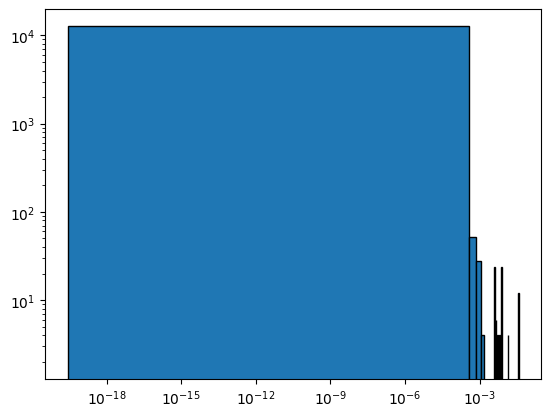

In [7]:
gradient = [x[0] for x in all_g]
print(gradient)
gradient = np.array(gradient)
gradient = abs(gradient)
plt.hist(abs(gradient), bins=100, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
print(max(gradient))
print(uop.a_idxs)

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
-5.0
reordered


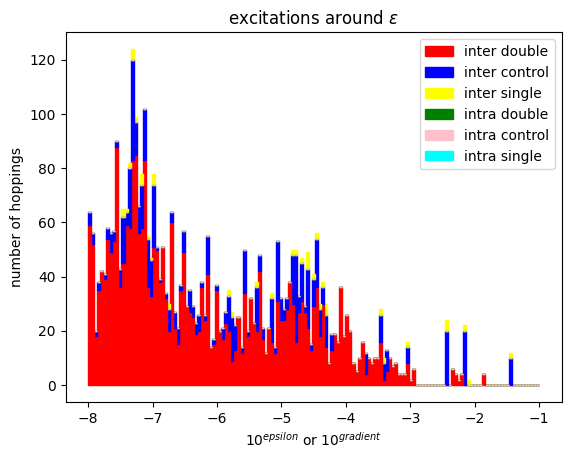

-5.0


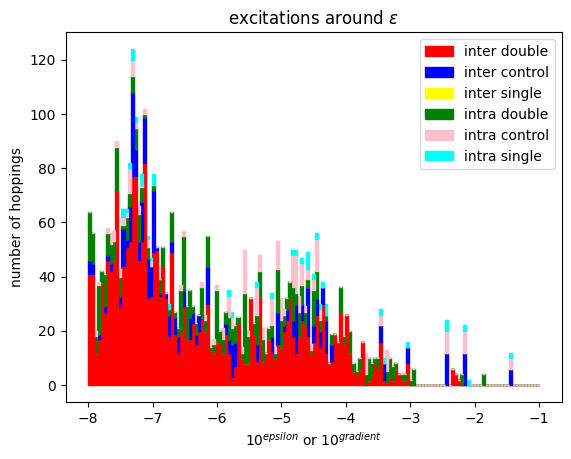

-5.0


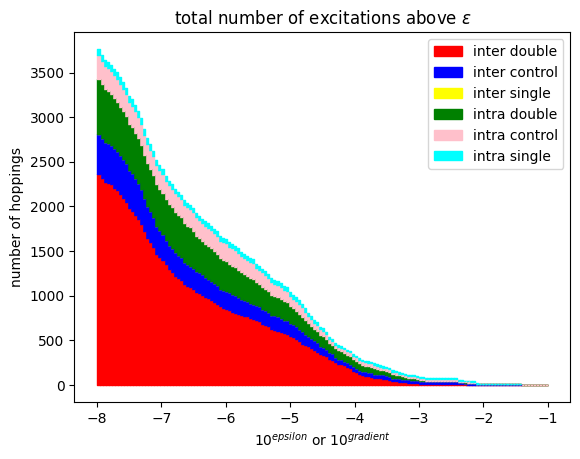

In [8]:
def plot_uop(uop, all_g, epsilon_min, seam_lst, epsilon_lst, f_orbs, total = True, ifinter = True, ifintra = True, ifreordered = True):
    e_min = np.log10(epsilon_min)//1
    print(e_min)
    nbins = len(epsilon_lst) - 1
    intra_double = np.zeros(nbins)
    inter_double = np.zeros(nbins)
    intra_control = np.zeros(nbins)
    inter_control = np.zeros(nbins)
    intra_single = np.zeros(nbins)
    inter_single = np.zeros(nbins)
    a_index = uop.a_idxs
    i_index = uop.i_idxs
    if ifreordered:
        print("reordered")
    for epsilon_index in range(len(epsilon_lst) - 1):
        epsilon_min = epsilon_lst[epsilon_index+1]
        if total:
            epsilon_max = np.inf
        else:
            epsilon_max = epsilon_lst[epsilon_index]
        for [gradient, i] in all_g:
            gradient = abs(gradient)
            if gradient > epsilon_min and gradient < epsilon_max:
                cur_index = epsilon_index
                cur_a = a_index[i].copy()
                cur_i = i_index[i].copy()
                # print("before reordering")
                # print(cur_a, cur_i)
                cur_excitation = [[cur_a, cur_i]]
                if ifreordered:
                    cur_excitation = orbital_reordering(cur_excitation,f_orbs)
                cur_a, cur_i = cur_excitation[0]
                # print("after reordering")
                # print(cur_a, cur_i)
                # print(cur_a, cur_i)
                if len(cur_a) == 1:
                    if cur_a == cur_i:
                        print("single evolution")
                    else:
                        # print("single hopping")
                        i1 = min([cur_a[0], cur_i[0]])
                        i2 = max([cur_a[0], cur_i[0]])
                        if i1 < seam and i2>=seam:
                            inter_single[cur_index] += 1
                        else:
                            intra_single[cur_index] += 1
                if len(cur_a) == 2:
                    cur_a.sort()
                    cur_i.sort()
                    p,q = cur_a
                    k,m = cur_i
                    if set(cur_a) & set(cur_i) != set():
                        j = list(set(cur_a) & set(cur_i))
                        j = j[0]
                        p,q = list(set(cur_a) ^ set(cur_i))
                        i1 = min([p,q,j])
                        i2 = max([p,q,j])
                        if i1 < seam and i2>=seam:
                            inter_control[cur_index] += 1
                        else:
                            intra_control[cur_index] += 1
                    else:
                        index_lst = [p,q,k,m]
                        index_lst.sort()
                        i1,i2,i3,i4 = index_lst
                        if i1 < seam and i4>=seam:
                            inter_double[cur_index] += 1
                        else:
                            intra_double[cur_index] += 1
    colors = ["red", "blue", "yellow", "green", "pink", "cyan"]
    for i in range(nbins):
        start = 0
        if ifinter:
            # Plot inter hopping
            plt.fill_betweenx([start, start+inter_double[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[0])
            start += inter_double[i]
            
            plt.fill_betweenx([start, start+inter_control[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[1])
            start += inter_control[i]

            plt.fill_betweenx([start, start+inter_single[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[2])
        if ifintra:
            # Intra hopping
            plt.fill_betweenx([start, start+intra_double[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[3])
            start += intra_double[i]

            plt.fill_betweenx([start, start+intra_control[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[4])
            start += intra_control[i]
            if intra_single[i]!=0:
                plt.fill_betweenx([start, start+intra_single[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[5])
                start += intra_single[i]

    if not ifintra:
        legend_handles = [
        mpatches.Patch(color=colors[0], label='inter double'),
        mpatches.Patch(color=colors[1], label='inter control'),
        mpatches.Patch(color=colors[2], label='inter single'),
    ]
    elif not ifinter:
        legend_handles = [
        mpatches.Patch(color=colors[3], label='intra double'),
        mpatches.Patch(color=colors[4], label='intra control'),
        mpatches.Patch(color=colors[5], label='intra single'),
    ]
    else:
        legend_handles = [
            mpatches.Patch(color=colors[0], label='inter double'),
            mpatches.Patch(color=colors[1], label='inter control'),
            mpatches.Patch(color=colors[2], label='inter single'),
            mpatches.Patch(color=colors[3], label='intra double'),
            mpatches.Patch(color=colors[4], label='intra control'),
            mpatches.Patch(color=colors[5], label='intra single'),
        ]
    if total:
        if not ifintra:
            plt.title(r"total number of inter-module excitations above $\epsilon$")
        elif not ifinter:
            plt.title(r"total number of intra-module excitations above $\epsilon$")
        else:
            plt.title(r"total number of excitations above $\epsilon$")
    else:
        if not ifintra:
            plt.title(r"inter-module excitations around $\epsilon$")
        elif not ifinter:
            plt.title(r"intra-module excitations around $\epsilon$")
        else:
            plt.title(r"excitations around $\epsilon$")
    plt.legend(handles=legend_handles)
    plt.xlabel(r"$10^{epsilon}$ or $10^{gradient}$")
    plt.ylabel("number of hoppings")
    plt.show()

    return inter_single, intra_single, inter_control, intra_control, inter_double, intra_double
epsilon = 0.01
uop, all_g = read_uop(1, epsilon,prehead)
epsilon_lst = [3e-3, 1e-3, 7e-4, 5e-4, 3e-4, 1e-4, 7e-5, 5e-5, 3e-5, 1e-5]
# epsilon_lst = [1e-3, 7e-4, 5e-4]
epsilon_lst = np.linspace(1,8,150)
epsilon_lst = 10**-(epsilon_lst)
f_orbs = [6,6]
seam = 12
epsilon_lst = np.array(epsilon_lst)
inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, seam,epsilon_lst, f_orbs, total=False,ifreordered=True)
inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, seam,epsilon_lst, f_orbs, total=False,ifreordered=False)
inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, seam,epsilon_lst, f_orbs, total=True,ifreordered=False)

# inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, [8,16],epsilon_lst, f_orbs)

-5.0


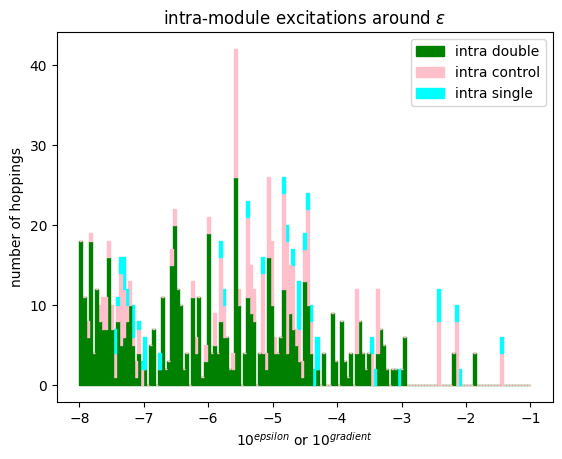

In [9]:
inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, [8,16],epsilon_lst, f_orbs, total=False, ifinter=False, ifreordered=False)


-5.0
reordered


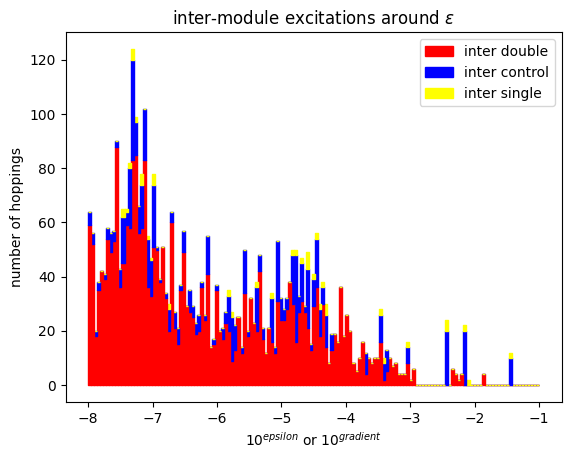

In [10]:
inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, [8,16],epsilon_lst, f_orbs, total=False, ifintra=False)


In [11]:
print(f"The total number of excitations when e = {epsilon_lst[-1]} is")
print(intra_control[-1] + inter_control[-1] + intra_double[-1] + inter_double[-1] + intra_single[-1] + inter_single[-1])

The total number of excitations when e = 1e-08 is
64.0


In [12]:
def create_excitation(uop, all_g, epsilon):
    excitations = []
    a_index = uop.a_idxs
    i_index = uop.i_idxs
    for [gradient, i] in all_g:
        gradient = abs(gradient)
        if gradient > epsilon:
            cur_a = a_index[i].copy()
            cur_i = i_index[i].copy()
            cur_excitation = [cur_a, cur_i]
            excitations.append(cur_excitation)
    return excitations

In [13]:
epsilon = 1e-3
seam_lst = [12]
ratio = 1
f_orbs = [2,24]
excitations = create_excitation(uop, all_g, epsilon)
# excitations = orbital_reordering(excitations, f_orbs)
tiles = create_circuit_tile(excitations)
inter_tile, intra_tile = split_grid(tiles, seam_lst)
inter_tile = expand_tiles(inter_tile, ratio)
tiles = inter_tile + intra_tile
tiles = sorted(tiles, key=lambda x: sum(w * h for w, h, _, _ in x), reverse=True)
filename = "../test_tiles.txt"
print(f"The length of excitations of epsilon = {epsilon} from raw data is")
print(len(excitations))
# tiles = create_circuit_tile(excitations)
# test_tiles = sorted(tiles, key=lambda x: sum(w * h for w, h, _, _ in x), reverse=True)
export_tiles_to_file(tiles, filename)

The length of excitations of epsilon = 0.001 from raw data is
88
Tiles successfully exported to ../test_tiles.txt


c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src
Bounding width: 2816
[(0, [(34, 17, 0, 6)]), (34, [(34, 17, 0, 6)]), (68, [(34, 17, 0, 6)]), (102, [(34, 17, 0, 6)]), (136, [(30, 16, 0, 7)]), (166, [(30, 16, 0, 7)]), (196, [(30, 16, 0, 7)]), (226, [(30, 16, 0, 7)]), (256, [(24, 17, 0, 0)]), (280, [(24, 17, 0, 0)]), (304, [(24, 17, 0, 0)]), (328, [(24, 17, 0, 0)]), (352, [(26, 15, 0, 8)]), (378, [(26, 15, 0, 8)]), (404, [(26, 15, 0, 8)]), (430, [(26, 15, 0, 8)]), (456, [(20, 16, 0, 0)]), (476, [(20, 16, 0, 0)]), (496, [(20, 16, 0, 0)]), (516, [(20, 16, 0, 0)]), (536, [(24, 12, 0, 6)]), (560, [(24, 12, 0, 6)]), (584, [(24, 12, 0, 6)]), (608, [(24, 12, 0, 6)]), (632, [(22, 11, 0, 12)]), (654, [(22, 11, 0, 12)]), (676, [(22, 11, 0, 12)]), (698, [(22, 11, 0, 12)]), (632, [(22, 11, 0, 0)]), (654, [(22, 11, 0, 0)]), (676, [(22, 11, 0, 0)]), (698, [(22, 11, 0, 0)]), (720, [(16, 15, 0, 0)]), (736, [(16, 15, 0, 0)]), (752, [(16, 15, 0, 0)]), (768, [(16, 15, 0, 0)]), (784, [(16, 14, 0,

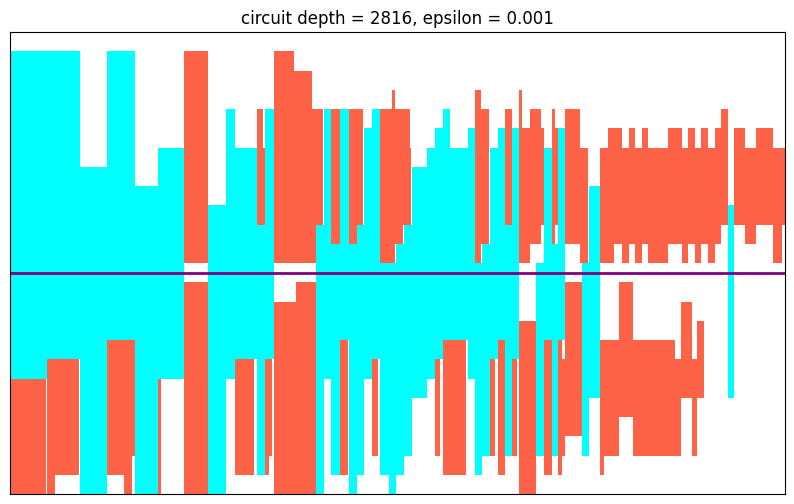

In [14]:
import subprocess

print(os.getcwd())

# Run the C executable directly (assuming it's compiled and named 'tile_packing.exe')
subprocess.run(["./lib/tile_packing.exe", "output.txt"])


filename = '../placed_tiles.txt'
bounding_width, placed_tiles = read_placed_tiles(filename)
print(placed_tiles)
placed_tiles = TilePacker(placed_tiles, bounding_width, N)
placed_tiles.draw_packing([],[12],epsilon,inter_color="cyan")



In [15]:
epsilon = 5e-3
N = 24
f_orbs = (2,2,2,2,2,2)
prehead = "../data_cr2_12o/"
# prehead = "../data_H_12/"
uop, all_g = read_uop(1, 0.01, prehead)
# uop, all_g = read_uop(1.5, 0.0,prehead)
excitations = create_excitation(uop, all_g, epsilon)

# excitations = orbital_reordering(excitations, f_orbs)
time_gate_with_C(excitations, N, epsilon)

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
sorted
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 1590
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 1664
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 1740
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding wid

KeyboardInterrupt: 

In [ ]:
epsilon = 5e-4
N = 24
f_orbs = (2,2,2,2,2,2)
prehead = "../data_cr2_12o/"
# prehead = "../data_H_12/"
uop, all_g = read_uop(1, 0.01, prehead)
# uop, all_g = read_uop(1.5, 0.0,prehead)
excitations = create_excitation(uop, all_g, epsilon)
ratio_lst = np.linspace(1, 20, 20, dtype="int")
post_gate_lst = np.zeros(len(ratio_lst))
seam = 12
for i in range(len(ratio_lst)):
    print(f"current ratio is {ratio_lst[i]}")
    ratio = ratio_lst[i]
    excitations = create_excitation(uop, all_g, epsilon)
    tiles = create_circuit_tile(excitations)
    inter_tiles, intra_tiles = split_grid(tiles, [seam])
    inter_tiles = expand_tiles(inter_tiles, ratio)
    tiles = inter_tiles + intra_tiles
    
    bounding_width, placed_tiles = packing_with_c(tiles)
    post_gate_lst[i] = bounding_width * 25


Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
current ratio is 1
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 5130
current ratio is 2
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 5516
current ratio is 3
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 5880
current ratio is 4
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835

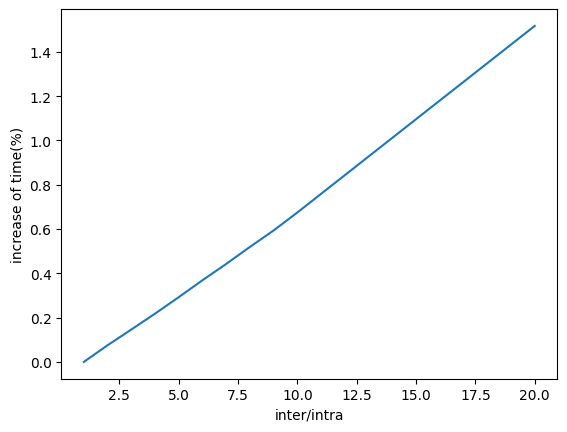

In [ ]:
post_gate_lst = np.array(post_gate_lst)
initial_gate = post_gate_lst[0]
diff = post_gate_lst - initial_gate
plt.plot(ratio_lst, diff/initial_gate)
plt.xlabel("inter/intra")
plt.ylabel("increase of time(%)")
post_gate_lst.tolist()
ratio_lst.tolist()
result = [ratio_lst, post_gate_lst]
np.save(f"../Cr2_6e_12o_transition/epsilon = {epsilon}.npy", result)

[ 0.1  1.1  2.1  3.1  4.1  5.1  6.1  7.1  8.1  9.1 10.1 11.1 12.1 13.1
 14.1 15.1 16.1 17.1 18.1 19.1]


Text(0.5, 1.0, 'Cr2_12e_6o')

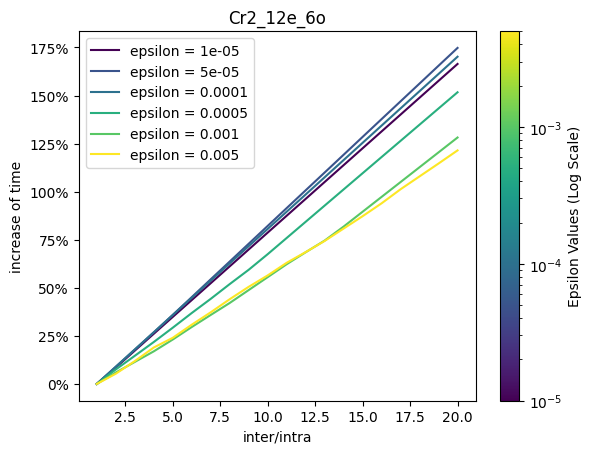

In [ ]:
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# epsilon_lst = [0.001,0.0007,0.0005, 0.0003 ,0.0001,0.00001]

epsilon_lst = [1e-3, 1e-4, 5e-3, 5e-4, 1e-5, 5e-5]
epsilon_lst.sort()
# Normalize epsilon values for color mapping
norm = mcolors.LogNorm(vmin=min(epsilon_lst), vmax=max(epsilon_lst))
cmap = plt.cm.viridis
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessary for ScalarMappable without data

# Create figure and axis
fig, ax = plt.subplots()

for epsilon in epsilon_lst:
    result = np.load(f"../Cr2_6e_12o_transition/epsilon = {epsilon}.npy")
    ratio_lst1 = result[0]
    post_gate_lst1 = result[1]
    initial_gate = post_gate_lst1[0]
    diff = post_gate_lst1 - initial_gate
    color = cmap(norm(epsilon))
    plt.plot(ratio_lst1, diff/initial_gate, label = f"epsilon = {epsilon}",color=color)
    plt.xlabel("inter/intra")
    plt.ylabel("increase of time")
ratio_lst1 = np.array(ratio_lst1)
print(ratio_lst1-0.9)
plt.legend()
# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Epsilon Values (Log Scale)')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Cr2_12e_6o")